In [24]:
import cv2
import mediapipe as mp
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import pairwise_distances
#import utils
#import tflite_runtime.interpreter as tflite
import matplotlib.pyplot as plt
import math

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

In [23]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.4 MB/s 


In [ ]:
model = tf.keras.models.load_model('./models/mpALL77_shuffle.h5')

In [ ]:
interpreter = tflite.Interpreter(model_path='./models/pose_landmark_full.tflite')
interpreter.allocate_tensors()

In [ ]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 337,
  'shape': array([  1, 195]),
  'shape_signature': array([  1, 195]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'Identity_1',
  'index': 342,
  'shape': array([1, 1]),
  'shape_signature': array([1, 1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'Identity_2',
  'index': 297,
  'shape': array([  1, 256, 256,   1]),
  'shape_signature': array([  1, 256, 256,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters':

In [43]:
image_path = '/content/tree3.gif'

image_path2 = '/content/tree4.gif'
cap1 = cv2.VideoCapture(image_path)
cap2 = cv2.VideoCapture(image_path2)

In [26]:
def get_pose_coord(landmarks1, landmarks2):
    pose1= []
    pose2= []
    for idx, landmark in enumerate(landmarks1):
        x = landmark.x
        y = landmark.y
        z = landmark.z
        pose1.append((x,y,z))

    for idx, landmark in enumerate(landmarks2):
        x = landmark.x
        y = landmark.y
        z = landmark.z
        pose2.append((x,y,z))
    
    return (pose1, pose2)


    

In [27]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [28]:
def compute_similarity(pose_1, pose_2):
    p1 = []
    p2 = []

    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        z1 = pose_1[joint][2]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]
        z2 = pose_2[joint][2]

        p1.append(x1)
        p1.append(y1)
        p1.append(z1)
        p2.append(x2)
        p2.append(y2)
        p2.append(z2)

    p1 = np.array(p1,dtype=float)
    p2 = np.array(p2,dtype=float)
    x = [p1,p2]
    euclid = pairwise_distances(x)[0][1]
    cosine = pairwise_distances(x, metric = 'cosine')[0][1]
    
    p1_cos = p1*1000
    p2_cos = p2*1000

    return ("Cosine:",cosine_similarity(p1_cos,p2_cos),"Euclidian:",euclid,"Chebyshev:", pairwise_distances(x, metric='chebyshev')[0][1])
    #return pairwise_distances(x, metric='correlation') 
    


In [29]:
def get_model_prediction(results1, results2):
  pose1, pose2 = get_pose_coord(results1.pose_landmarks.landmark, results2.pose_landmarks.landmark)
  pose1 = np.array(pose1)
  pose2 = np.array(pose2)

  point = results1.pose_world_landmarks.landmark
  lists1 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

  point = results2.pose_world_landmarks.landmark
  lists2 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

  inp = np.concatenate([lists1, lists2]).flatten().reshape(1, 264)
  pred = model.predict(inp)
  return pred[0][0]

In [34]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1= landmark1.x, landmark1.y
    x2, y2 = landmark2.x, landmark2.y
    x3, y3 = landmark3.x, landmark3.y

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

In [32]:
def get_angles(landmarks):

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    return [left_elbow_angle, right_elbow_angle, left_shoulder_angle, right_shoulder_angle, left_knee_angle, right_knee_angle]

    

In [36]:
def get_non_matching_joints(angles1, angles2):
  angles_diff = np.array(angles1) - np.array(angles2)
  names = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder', 'left_knee', 'right_knee']

  names = np.array(names)
  out = [abs(x)/10 for x in angles_diff]

  bool_arr = np.array([0 if x<=1 else 1 for x in out])

  fin = np.where(bool_arr, names,'')

  return list(filter(None, fin))

In [44]:
count = 0
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.6) as Pose_model1:
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.6) as Pose_model2:
        while cap1.isOpened() and cap2.isOpened():
            time.sleep(0.5)
            
            ret1, frame1 = cap1.read()
            ret2, frame2 = cap2.read()
            


            if ret1 and ret2:
                frame_height = max(frame1.shape[0], frame2.shape[0])
                frame_width = max(frame1.shape[1], frame2.shape[1])
                bg_image = np.zeros((frame_height, frame_width,3), dtype=np.uint8)
                frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
                frame1.flags.writeable= False
                frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
                frame2.flags.writeable= False

                results1 = Pose_model1.process(frame1)
                results2 = Pose_model2.process(frame2)

                frame1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR)
                frame1.flags.writeable= True
                frame2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR)
                frame2.flags.writeable= True

                pose1, pose2 = get_pose_coord(results1.pose_landmarks.landmark, results2.pose_landmarks.landmark)
                pose1 = np.array(pose1)
                pose2 = np.array(pose2)
                #score = compute_similarity(pose1, pose2)
                # prediction = get_model_prediction(results1, results2)
                # print("Prediction" , prediction)
                angles1 = get_angles(results1.pose_landmarks.landmark)
                angles2 = get_angles(results2.pose_landmarks.landmark)
                print(get_non_matching_joints(angles1, angles2))

                if(count == 10):
                    
                    count = 0
                else:
                    count+=1

                mp_drawing.draw_landmarks(
                frame1,
                results1.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

                mp_drawing.draw_landmarks(
                frame2,
                results2.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

                mp_drawing.draw_landmarks(
                bg_image,
                results1.pose_landmarks,
                mp_pose.POSE_CONNECTIONS)

                mp_drawing.draw_landmarks(
                bg_image,
                results2.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing_styles.DrawingSpec(color =(245,117,66),thickness = 2, circle_radius=2 ),
                mp_drawing_styles.DrawingSpec(color =(245,66,230),thickness = 2, circle_radius=2 ))
                #cv2.imshow("Vid1", frame1)
                #cv2.imshow("vid2", frame2)

                try:
                    str = "Prediction:" + prediction.astype('str')
                except:
                    str = "Prediction: --" 

                font                   = cv2.FONT_HERSHEY_SIMPLEX
                bottomLeftCornerOfText = (10,frame_height - 10)
                fontScale              = 1
                fontColor              = (255,255,255)
                thickness              = 1
                lineType               = 2
                cv2.putText(bg_image,str, 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                thickness,
                lineType)
                #cv2.imshow("Combined", bg_image)

                cv2.imwrite('./out/combined/' + np.array([count]).astype('str')[0] + '.png', bg_image)
                cv2.imwrite('./out/vid1/' + np.array([count]).astype('str')[0] + '.png', frame1)
                cv2.imwrite('./out/vid2/' + np.array([count]).astype('str')[0] + '.png', frame2)


            else:
                break


            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

cap1.release()
cap2.release()
cv2.destroyAllWindows()

['left_elbow', 'right_elbow', 'right_shoulder', 'right_knee']
['left_elbow', 'right_elbow', 'right_shoulder', 'right_knee']
['right_elbow', 'left_shoulder', 'right_shoulder', 'right_knee']
['left_elbow', 'right_elbow', 'right_shoulder', 'right_knee']
['left_elbow', 'right_elbow', 'right_shoulder', 'right_knee']


In [ ]:
results1.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value]

x: 0.5827085
y: 0.22974643
z: -0.15845491
visibility: 0.9998728

In [ ]:
cap1 = cv2.VideoCapture(image_path)

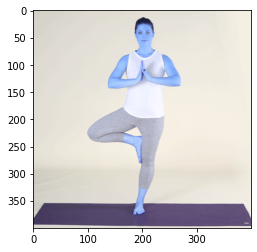

In [ ]:
ret1, frame1 = cap1.read()
plt.imshow(frame1)

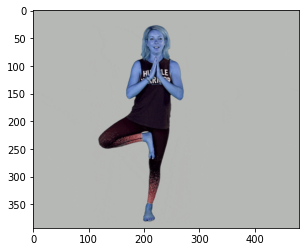

In [ ]:
ret1, frame2 = cap2.read()
plt.imshow(frame2)

In [ ]:
Pose_model1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.6) 
Pose_model2 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.6)
count =0

In [ ]:
frame_height = max(frame1.shape[0], frame2.shape[0])
frame_width = max(frame1.shape[1], frame2.shape[1])
bg_image = np.zeros((frame_height, frame_width,3), dtype=np.uint8)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame1.flags.writeable= False
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame2.flags.writeable= False

results1 = Pose_model1.process(frame1)
results2 = Pose_model2.process(frame2)

frame1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR)
frame1.flags.writeable= True
frame2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR)
frame2.flags.writeable= True

pose1, pose2 = get_pose_coord(results1.pose_landmarks.landmark, results2.pose_landmarks.landmark)
pose1 = np.array(pose1)
pose2 = np.array(pose2)
#score = compute_similarity(pose1, pose2)
# prediction = get_model_prediction(results1, results2)
# print("Prediction" , prediction)
angles1 = get_angles(results1.pose_landmarks.landmark)
angles2 = get_angles(results2.pose_landmarks.landmark)

print(np.array(angles1) - np.array(angles2))
if(count == 100):
    
    count = 0
else:
    count+=1

mp_drawing.draw_landmarks(
frame1,
results1.pose_landmarks,
mp_pose.POSE_CONNECTIONS,
landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

mp_drawing.draw_landmarks(
frame2,
results2.pose_landmarks,
mp_pose.POSE_CONNECTIONS,
landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

mp_drawing.draw_landmarks(
bg_image,
results1.pose_landmarks,
mp_pose.POSE_CONNECTIONS)

mp_drawing.draw_landmarks(
bg_image,
results2.pose_landmarks,
mp_pose.POSE_CONNECTIONS,
mp_drawing_styles.DrawingSpec(color =(245,117,66),thickness = 2, circle_radius=2 ),
mp_drawing_styles.DrawingSpec(color =(245,66,230),thickness = 2, circle_radius=2 ))
#cv2.imshow("Vid1", frame1)
#cv2.imshow("vid2", frame2)

try:
    str = "Prediction:" + prediction.astype('str')
except:
    str = "Prediction: --" 

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,frame_height - 10)
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2
cv2.putText(bg_image,str, 
bottomLeftCornerOfText, 
font, 
fontScale,
fontColor,
thickness,
lineType)
#cv2.imshow("Combined", bg_image)

cv2.imwrite('./out/combined/' + np.array([count]).astype('str')[0] + '.png', bg_image)
cv2.imwrite('./out/vid1/' + np.array([count]).astype('str')[0] + '.png', frame1)
cv2.imwrite('./out/vid2/' + np.array([count]).astype('str')[0] + '.png', frame2)


[-23.42774913  27.18481845  16.19481417  22.55721683   2.16394198
   6.16131674]


False

In [ ]:
count

1

In [ ]:
img = frame1.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis =0), 256,256)
inp_img= tf.cast(img, dtype=tf.float32)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(interpreter.get_input_details()[0]['index'], np.array(inp_img))
interpreter.invoke()

keypoints_with_score = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
keypoints_with_score[0][0:5]

array([108.91081  ,  60.9013   , -55.52106  ,   1.3596296,  -0.9974822],
      dtype=float32)

In [ ]:
pose1, pose2 = get_pose_coord(results1.pose_landmarks.landmark, results2.pose_landmarks.landmark)
pose1 = np.array(pose1)
pose2 = np.array(pose2)

In [ ]:
point = results1.pose_world_landmarks.landmark
lists1 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

point = results2.pose_world_landmarks.landmark
lists2 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

In [ ]:
out = np.concatenate([lists1, lists2]).flatten()
out.shape

(264,)

In [ ]:
q = np.array([[pose1[1][0]],[pose1[1][1]],[pose1[14][0]],[pose1[14][1]]], np.float)

p = np.array([[pose2[1][0], pose2[1][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[1][0], pose2[1][1], 1.0], \
              [pose2[14][0], pose2[14][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[14][0], pose2[14][1], 1.0]], np.float)

A, res, rank, s = np.linalg.lstsq(p, q)

T = np.array([[A[0], A[1], A[2]],[A[3], A[4], A[5]],[0.0, 0.0, 1.0]], np.float)

<ipython-input-48-7a02d6fef2a7>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(p, q)


In [ ]:
pose2[1]

array([ 0.4764939 ,  0.25848323, -0.34960312])

In [ ]:
pose2_new = []

for elt in pose2:
        
        cur_pt = np.array([elt[0],elt[1],1])
        transformed_pt = T.dot(cur_pt)
        
        transformed_pt = transformed_pt / transformed_pt[2]
        pose2_new.append((int(transformed_pt[0]), int(transformed_pt[1])))

In [ ]:
compute_similarity(pose1,pose2_new)

<ipython-input-4-90e4ff436f1a>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))


(nan, 4.12418172832816, nan)

In [ ]:
ar1 = np.random.randn(6,)
ar2 = np.random.randn(6,)
cosine_similarity(ar1, ar2)

0.12946394957809082

In [ ]:
max(frame1.shape[0], frame2.shape[0])

338

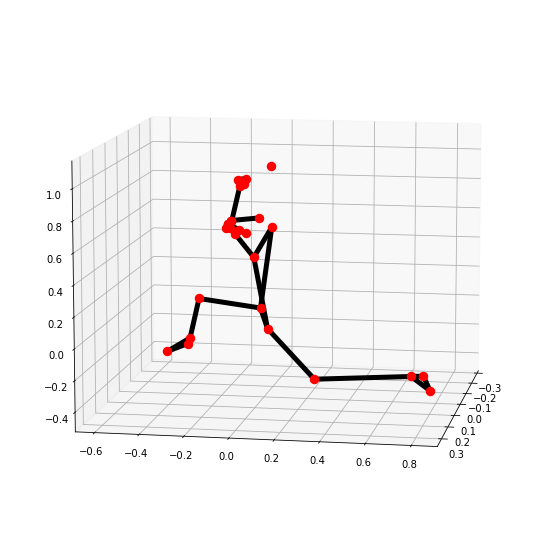

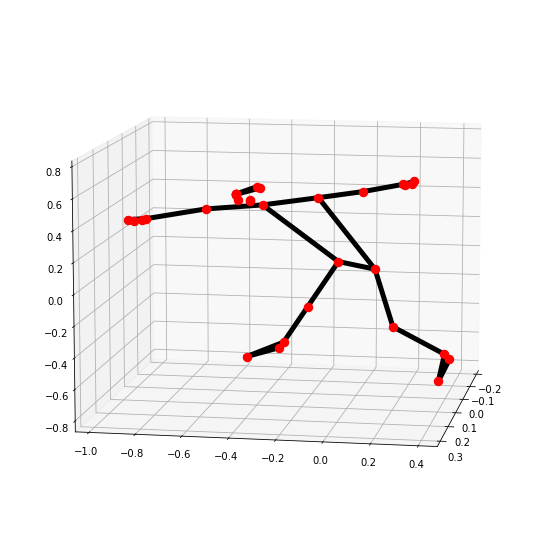

: 

In [ ]:
mp_drawing.plot_landmarks(
        results1.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
mp_drawing.plot_landmarks(
        results2.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)